In [1]:
import gym
import gym.spaces
from gym.utils import seeding
from gym.envs.registration import EnvSpec
import enum
import numpy as np
import pandas as pd
from pathlib import Path
import sys
import sklearn
import tensorflow as tf
from tensorflow import keras
np.random.seed(42)
tf.random.set_seed(42)
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import math

In [2]:
from gym import Env
from gym.spaces import Discrete, Box
import random

In [3]:
import time

In [4]:
import tensorflow_probability as tfp
import tensorflow.keras.losses as kls

In [5]:
DEFAULT_BARS_COUNT = 63
DEFAULT_COMMISSION_PERC = 0.0025
DEFAULT_RISK_DISCOUNT = 0.001

In [6]:
def WMA(data, period=20):
    wma = []
    divisor = (period*(period+1))/2
    for i in range(len(data)):
        div = divisor
        num = 0
        for a in range(period):;
            if (i-a) >= 0:
                num += data[i-a] * (period - a)
            elif (i-a) < 0:
                div -= period - a
        num = num/div
        wma.append(num)
    return np.array(wma)

In [7]:
def hull_ma(data, period=20):
    half = round(period/2)
    wma1 = WMA(data, half)
    wma2 = WMA(data, period)
    raw_wma = (2*wma1) - wma2
    sqrt = round(period ** 0.5)
    hma = WMA(raw_wma, sqrt)
    return hma

In [8]:
class PMA_Env(Env):
    metadata = {'render.modes': ['human']}
    spec = EnvSpec('StocksEnv-v0') #not quite sure what this does, but 
    #i might change the name
    
    def __init__(self, msft_prices, dis_prices, jnj_prices, libor, bars_count = DEFAULT_BARS_COUNT,
                commission_perc = DEFAULT_COMMISSION_PERC, risk_discount = DEFAULT_RISK_DISCOUNT, 
                 random_ofs_on_reset=True, noise_on=True):
    
        self._msft_prices = msft_prices
        self._dis_prices = dis_prices
        self._jnj_prices = jnj_prices
        
        self._libor = libor
        self.noise_on = noise_on
        self.bars_count = bars_count
        self.commission_perc = commission_perc
        self.risk_discount = risk_discount
        self.random_ofs_on_reset = random_ofs_on_reset
    
        self._state = State(msft_prices, dis_prices, jnj_prices, libor, 
                            bars_count, commission_perc, risk_discount, random_ofs_on_reset, noise_on)
    
    def step(self, action, risk_discount):
        reward, done, return_ = self._state.step(action, risk_discount)
        
        msft_prices = self._msft_prices
        dis_prices = self._dis_prices
        jnj_prices = self._jnj_prices
        
        libor = self._libor
        
        obs = self._state.encode(msft_prices, dis_prices, jnj_prices, libor)
        info = {
            'offset': self._state._offset
            #maybe add more
        }
        return obs, reward, done, info, return_
    
    def reset(self):
        msft_prices = self._msft_prices
        dis_prices = self._dis_prices
        jnj_prices = self._jnj_prices
        
        libor = self._libor
        
        bars = self._state.bars_count
        if self.random_ofs_on_reset:
            offset = np.random.choice(
                msft_prices.close.shape[0]-bars*10) + bars
        else:
            offset = bars
        self._state.reset(msft_prices, dis_prices, jnj_prices, self._libor, offset)
        return self._state.encode(msft_prices, dis_prices, jnj_prices, libor)

In [9]:
class State:
    def __init__(self, msft_prices, dis_prices, jnj_prices, libor, bars_count, 
                 commission_perc, risk_discount, random_ofs_on_reset, noise_on=True):
        assert isinstance(bars_count, int)
        assert bars_count > 0
        assert isinstance(commission_perc, float)
        assert commission_perc >= 0.0
        self.bars_count = bars_count
        self.commission_perc = commission_perc
        self.noise_on = noise_on
        self._libor = libor
        
    def reset(self, msft_prices, dis_prices, jnj_prices, libor, offset):
        assert isinstance(msft_prices, pd.DataFrame)
        assert isinstance(dis_prices, pd.DataFrame)
        assert isinstance(jnj_prices, pd.DataFrame)
        assert isinstance(libor, pd.DataFrame)
        assert offset >= self.bars_count-1
        self.weights = np.array([1, 0, 0, 0])
        self._msft_prices = msft_prices
        self._dis_prices = dis_prices
        self._jnj_prices = jnj_prices
        self.reward_cumsum = 0
        self.msft_noise = np.zeros(shape=self.shape)
        self.dis_noise = np.zeros(shape=self.shape)
        self.jnj_noise = np.zeros(shape=self.shape)
        self.dsr = 0
        self.a = 0
        self.b = 0

        self._offset = offset
        
    @property
    def shape(self):
        return (9, 4, self.bars_count)
       
    def encode(self, msft_prices, dis_prices, jnj_prices, libor):
        
        self._msft_prices = msft_prices
        self._dis_prices = dis_prices
        self._jnj_prices = jnj_prices
        
        self._libor = libor
        
        assert isinstance(self._libor, pd.DataFrame)
        
        res = np.zeros(shape=self.shape, dtype=np.float32)
        start = self._offset-(self.bars_count-1)
        stop = self._offset+1
        
        msft_std = np.std(msft_prices.close[start:stop])
        dis_std = np.std(dis_prices.close[start:stop])
        jnj_std = np.std(jnj_prices.close[start:stop])
        shape = msft_prices.close[start:stop].shape
        if self.noise_on:
            self.msft_noise = np.random.normal(loc=0, scale=0.1, size=shape)*(msft_std*0.1)
            self.dis_noise = np.random.normal(loc=0, scale=0.1, size=shape)*(dis_std*0.1)
            self.jnj_noise = np.random.normal(loc=0, scale=0.1, size=shape)*(jnj_std*0.1)
            #self.noise=noise[-1]
        elif not self.noise_on:
            noise = 0
            self.msft_noise = np.zeros(shape=shape)
            self.dis_noise = np.zeros(shape=shape)
            self.jnj_noise = np.zeros(shape=shape)
        
        res[0][0] = np.zeros(self.bars_count) + 1
        res[0][1] = np.log(msft_prices.close[start:stop])+ self.msft_noise
        res[0][2] = np.log(dis_prices.close[start:stop]) + self.dis_noise
        res[0][3] = np.log(jnj_prices.close[start:stop]) + self.jnj_noise
        
        res[1][0] = np.zeros(self.bars_count) + 1
        res[1][1] = np.log(msft_prices.high[start:stop])+ self.msft_noise
        res[1][2] = np.log(dis_prices.high[start:stop])+ self.dis_noise
        res[1][3] = np.log(jnj_prices.high[start:stop]) + self.jnj_noise
        
        res[2][0] = np.zeros(self.bars_count) + 1
        res[2][1] = np.log(msft_prices.low[start:stop])+ self.msft_noise
        res[2][2] = np.log(dis_prices.low[start:stop]) + self.dis_noise
        res[2][3] = np.log(jnj_prices.low[start:stop]) + self.jnj_noise
        
        #res[3][0] = np.zeros(self.bars_count) + 1
        #res[3][1] = np.log(msft_prices.open[start:stop])
        #res[3][2] = np.log(dis_prices.open[start:stop])
        #res[3][3] = np.log(jnj_prices.open[start:stop])
        
        res[3][0] = np.zeros(self.bars_count)
        res[3][1] = np.log(msft_prices.volume[start:stop])
        res[3][2] = np.log(dis_prices.volume[start:stop])
        res[3][3] = np.log(jnj_prices.volume[start:stop])
        
        res[4][0] = np.log(libor.three_month[start:stop])
        res[4][1] = np.log(libor.three_month[start:stop])
        res[4][2] = np.log(libor.three_month[start:stop])
        res[4][3] = np.log(libor.three_month[start:stop])
        
        res[5][0] = np.zeros(self.bars_count) - 1
        res[5][1] = msft_prices.signals[start:stop]
        res[5][2] = dis_prices.signals[start:stop]
        res[5][3] = jnj_prices.signals[start:stop]
        
        res[6][0] = np.zeros(self.bars_count)
        res[6][1] = msft_prices.conf[start:stop]
        res[6][2] = dis_prices.conf[start:stop]
        res[6][3] = jnj_prices.conf[start:stop]
                           
        for i in reversed(range(3)):
            res[i][1] = res[i][1] / res[0][1][-1]
            res[i][2] = res[i][2] / res[0][2][-1]
            res[i][3] = res[i][3] / res[0][2][-1]
                           
        for i in range(3):
            res[3][i+1] = res[3][i+1] / res[3][i+1][-1]
        
        res[7][0] = np.zeros(self.bars_count) + 1
        res[7][1] = hull_ma(res[0][1], 10)
        res[7][2] = hull_ma(res[0][2], 10)
        res[7][3] = hull_ma(res[0][3], 10)
        
        res[8][0] = np.zeros(self.bars_count) + self.weights[0]
        res[8][1] = np.zeros(self.bars_count) + self.weights[1]
        res[8][2] = np.zeros(self.bars_count) + self.weights[2]
        res[8][3] = np.zeros(self.bars_count) + self.weights[3]
        return res
    
    def _cur_close_changes(self, action):
        msft_change = self._msft_prices.close[self._offset+1]/(self._msft_prices.close[self._offset] + self.msft_noise[-1])
        dis_change = self._dis_prices.close[self._offset+1]/(self._dis_prices.close[self._offset] + self.dis_noise[-1])
        jnj_change = self._jnj_prices.close[self._offset+1]/(self._jnj_prices.close[self._offset] + self.jnj_noise[-1])
        
        return np.array([1, msft_change, dis_change, jnj_change])
    
    def _reward_function(self, action, changes, weights, risk_discount=0.001, n=0.011):
        performance = np.dot(changes, action)
        #print(performance)
        transaction_cost = self.commission_perc * np.sum([abs(action[i] - weights[i]) for i in range(4)])
        #print(transaction_cost)
        start = self._offset-(self.bars_count-1)
        stop = self._offset+1
        #return_ = performance - transaction_cost
        
        stock_std = np.array([0, np.std(np.log(self._msft_prices.close[start:stop])+self.msft_noise)**2,
                         np.std(np.log(self._dis_prices.close[start:stop])+self.dis_noise)**2,
                         np.std(np.log(self._jnj_prices.close[start:stop])+self.jnj_noise)**2])
        
        volatility = np.dot(stock_std, action)
        return_ = performance - transaction_cost
        #print(volatility)
        #print(return_)
        one_step_reward = np.log(performance - transaction_cost) - risk_discount*np.log(volatility)
        #self.reward_cumsum += one_step_reward 
        
        '''a = n*return_ + (1-n)*self.a
        b = n*(return_**2) + (1-n)*self.b
        delta_a = return_ - self.a
        delta_b = return_**2 - self.b
        
        dt = ((self.b*delta_a) - (0.5*self.a*delta_b))/(((self.b-(self.a**2))**1.5)+1e-7)
        dsr = n*dt
        if (self.a != 0) & (self.b != 0):
            self.dsr += dsr
        self.b = b
        self.a = a'''
        
        return one_step_reward, return_     
    
    def step(self, action, risk_discount):
        close_changes = self._cur_close_changes(action)
        done = False
        
        self._offset += 1
        
        if self._offset >= self._msft_prices.close.shape[0] - 1:
            done = True
            
        self.weights = (close_changes * action) / (np.dot(close_changes, action))
        reward, day_return = self._reward_function(action, close_changes, self.weights, risk_discount)
        
        return reward, done, day_return

In [10]:
with pd.HDFStore('my_model_data.h5') as store:
    msft_train = store['dow/stock_fund/pma/training/w_conf/msft']
    msft_valid = store['dow/stock_fund/pma/valid/w_conf/msft']
    dis_train = store['dow/stock_fund/pma/training/w_conf/dis']
    dis_valid = store['dow/stock_fund/pma/valid/w_conf/dis']
    jnj_train = store['dow/stock_fund/pma/training/w_conf/jnj']
    jnj_valid = store['dow/stock_fund/pma/valid/w_conf/jnj']

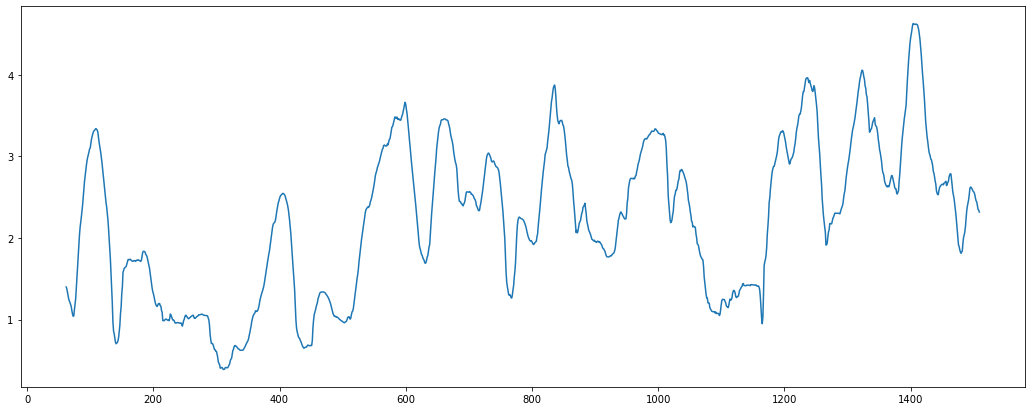

2.21689039265557


In [11]:
plt.figure(figsize=(18,7))
plt.plot(jnj_train.close.rolling(63).std())
plt.show()
print(jnj_train.close.rolling(63).std().mean())

In [13]:
with pd.HDFStore('my_model_data.h5') as store:
    msft_train = store['dow/stock_fund/EAM/training_section/w_hma/msft']
    msft_test = store['dow/stock_fund/EAM/testing_section/w_hma/msft']
    dis_train = store['dow/stock_fund/EAM/training_section/w_hma/dis']
    dis_test = store['dow/stock_fund/EAM/testing_section/w_hma/dis']
    jnj_train = store['dow/stock_fund/EAM/training_section/w_hma/jnj']
    jnj_test = store['dow/stock_fund/EAM/testing_section/w_hma/jnj']

In [14]:
with pd.HDFStore('sga_signals.h5') as store:
    msft_signals = store['sga/test/msft']
    dis_signals = store['sga/test/dis']
    jnj_signals = store['sga/test/jnj']

In [15]:
with pd.HDFStore('cga_signals.h5') as store:
    msft_conf = store['cga/test/arr/msft']
    dis_conf = store['cga/test/arr/dis']
    jnj_conf = store['cga/test/arr/jnj']

In [16]:
msft_test = msft_test[2012:]
dis_test = dis_test[2012:]
jnj_test = jnj_test[2012:]

In [17]:
msft_test.reset_index(inplace=True, drop=True)
dis_test.reset_index(inplace=True, drop=True)
jnj_test.reset_index(inplace=True, drop=True)

In [18]:
msft_signals = msft_signals[63:]
dis_signals = dis_signals[63:]
jnj_signals = jnj_signals[63:]

In [19]:
msft_signals.reset_index(inplace=True, drop=True)
dis_signals.reset_index(inplace=True, drop=True)
jnj_signals.reset_index(inplace=True, drop=True)

In [20]:
msft_test['signals'] = msft_signals
dis_test['signals'] = dis_signals
jnj_test['signals'] = jnj_signals

In [21]:
msft_test['conf'] = msft_conf
dis_test['conf'] = dis_conf
jnj_test['conf'] = jnj_conf

In [55]:
'''with pd.HDFStore('my_model_data.h5') as store:
    store.put('dow/stock_fund/pma/training/w_conf/msft', msft_train)
    #store.put('dow/stock_fund/pma/valid/w_conf/msft', msft_valid)
    store.put('dow/stock_fund/pma/training/w_conf/dis', dis_train)
    #store.put('dow/stock_fund/pma/valid/w_conf/dis', dis_valid)
    store.put('dow/stock_fund/pma/training/w_conf/jnj', jnj_train)
    #store.put('dow/stock_fund/pma/valid/w_conf/jnj', jnj_valid)'''

In [22]:
with pd.HDFStore('research.h5') as store:
    libor_train = store['libor/training_section/nochange/low_margin_interest']
    libor_valid = store['libor/validation_section/nochange/low_margin_interest']
    libor_test = store['libor/testing_section/nochange/low_margin_interest']

In [23]:
env = PMA_Env(msft_train, dis_train, jnj_train, libor_train)
valid_env = PMA_Env(msft_valid, dis_valid, jnj_valid, libor_valid, random_ofs_on_reset=False, noise_on=False)
test_env = PMA_Env(msft_test, dis_test, jnj_test, libor_test, random_ofs_on_reset=False, noise_on=False)

In [24]:
input_shape = (9, 4, 63)

In [18]:
#K = keras.backend 
#actor = keras.models.Sequential()
#actor.add(keras.layers.Conv2D(50, (1,4), strides=1, input_shape=input_shape, padding='same',
#                             activation='relu'))
#actor.add(keras.layers.BatchNormalization())
#actor.add(keras.layers.Conv2D(30, (1,4), strides=1, padding='same', activation='relu'))
#actor.add(keras.layers.BatchNormalization())
#actor.add(keras.layers.Conv2D(1, (1,4), strides=1, padding='same', activation='relu'))
#actor.add(keras.layers.BatchNormalization())
#actor.add(keras.layers.Conv2D(1, (8,1), strides=1, activation='relu'))
#actor.add(keras.layers.Flatten())
#actor.add(keras.layers.Activation('relu'))
#actor.add(keras.layers.Dense(128, activation='relu')) #not sure this should be here
#actor.add(keras.layers.Dense(4, activation='relu'))

In [25]:
K = keras.backend
input_states = keras.layers.Input(shape=input_shape)
conv1 = keras.layers.Conv2D(50, (1,4), strides=1, input_shape=input_shape, padding='same', 
                            activation='relu')(input_states)
conv2 = keras.layers.BatchNormalization()(conv1)
conv3 = keras.layers.Conv2D(30, (1,4), strides=1, padding='same', activation='relu')(conv2)
conv4 = keras.layers.BatchNormalization()(conv3)
conv5 = keras.layers.Conv2D(1, (1,4), strides=1, padding='same', activation='relu')(conv4)
conv6 = keras.layers.BatchNormalization()(conv5)
conv7 = keras.layers.Conv2D(1, (9,1), strides=1, activation='relu')(conv6)
flat = keras.layers.Flatten()(conv7)
output = keras.layers.Activation('relu')(flat)
actor = keras.models.Model(inputs=[input_states], outputs=[output]) #cash[0][0],stocks[0][1:]]

In [26]:
K = keras.backend 
critic = keras.models.Sequential()
critic.add(keras.layers.Conv2D(50, (1,4), strides=1, input_shape=input_shape, padding='same',
                             activation='relu'))
critic.add(keras.layers.BatchNormalization())
critic.add(keras.layers.Conv2D(30, (1,4), strides=1, padding='same', activation='relu'))
critic.add(keras.layers.BatchNormalization())
critic.add(keras.layers.Conv2D(1, (1,4), strides=1, padding='same', activation='relu'))
critic.add(keras.layers.BatchNormalization())
critic.add(keras.layers.Conv2D(1, (9,1), strides=1, activation='relu'))
critic.add(keras.layers.Flatten())
#critic.add(keras.layers.Dense(128, activation='relu')) #not sure this should be here
critic.add(keras.layers.Dense(1, activation='relu'))

In [46]:
actor.load_weights('PMA_actor_crp_500episodes.h5')
#critic.load_weights('SAM_EIIE_critic_500episodes.h5')

In [20]:
actor.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 9, 4, 63)]   0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 9, 4, 50)     12650       ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 9, 4, 50)    200         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 conv2d_1 (Conv2D)              (None, 9, 4, 30)     6030        ['batch_normalization[0][0]']

In [29]:
gamma = 0.99
clip_param = 0.2

In [30]:
def act(state):
    means = actor(state[np.newaxis])
    bill = keras.activations.get('softmax')
    return bill(means).numpy()

In [31]:
def actor_loss(probs, adv, old_probs):
    probability = probs
    entropy = tf.reduce_mean(tf.math.negative(tf.math.multiply(probability+1e-7,tf.math.log(probability+1e-7))))
    #print(probability)
    #print(entropy)
    sur1 = []
    sur2 = []
        
    for pb, t, op in zip(probability, adv, old_probs):
        t = tf.constant(t)
        op = tf.constant(op)
        #print(t)
        ratio = tf.reduce_mean(tf.math.exp(tf.math.log(pb + 1e-7) - tf.math.log(op + 1e-7)))
        #print(ratio)
        s1 = tf.math.multiply(ratio, t)
        #print(s1)
        s2 = tf.math.multiply(tf.clip_by_value(ratio, 1.0 - clip_param, 1.0+clip_param), t)
        #print(s2)
        sur1.append(s1)
        sur2.append(s2)
            
    sr1 = tf.stack(sur1)
    sr2 = tf.stack(sur2)
        
    loss = tf.math.negative(tf.reduce_mean(tf.math.minimum(sr1, sr2)) + 0.001*entropy)
    #print(loss)
    return loss

In [32]:
def batch_maker(batch_size=50):
    indices = np.random.randint(len(replay_buffer), size=batch_size)
    batch = [replay_buffer[index] for index in indices]
    states, adv, probs, rewards = [np.array([experience[field_index] for experience in batch])
                                  for field_index in range(4)]
    
    #batch_states = [states[index] for index in indices]
    #batch_adv = [adv[index] for index in indices]
    #batch_probs = [probs[index] for index in indices]
    #batch_reward_lst = [reward_list[index] for index in indices]
    
    return states, adv, probs, rewards

In [33]:
def learn(batch_size):
    
    #discount_rewards = tf.reshape(discount_rewards, (len(discount_rewards),))
    #adv = tf.reshape(adv, (len(adv),))
    #old_p = old_probs
    #old_p = tf.reshape(old_p, (len(old_p),4))
    
    batch_states, batch_adv, batch_old_p, batch_discount_rewards = batch_maker(batch_size)
    
    with tf.GradientTape() as tape1, tf.GradientTape() as tape2:
        p = actor(batch_states) #what the frcikle frack
        #print(p)
        v = critic(batch_states)
        v = tf.reshape(v, (len(v),))
        #print(v)
        td = tf.math.subtract(batch_discount_rewards, v)
        c_loss = 0.5 * kls.mean_squared_error(batch_discount_rewards, v)
        a_loss = actor_loss(p, batch_adv, batch_old_p)
            
    grads1 = tape1.gradient(a_loss, actor.trainable_variables)
    grads2 = tape2.gradient(c_loss, critic.trainable_variables)
    a_optimizer.apply_gradients(zip(grads1, actor.trainable_variables))
    c_optimizer.apply_gradients(zip(grads2, critic.trainable_variables))
    return a_loss, c_loss

In [34]:
def loss_calculator(states, adv, old_p, discount_rewards):
    with tf.GradientTape() as tape1, tf.GradientTape() as tape2:
        p = actor(np.array(states)) #what the frcikle frack
        #print(p)
        v = critic(np.array(states))
        v = tf.reshape(v, (len(v),))
        #print(v)
        td = tf.math.subtract(discount_rewards, v)
        c_loss = 0.5 * kls.mean_squared_error(discount_rewards, v)
        a_loss = actor_loss(p, adv, old_p)
    
    return a_loss, c_loss

In [35]:
def validation_run():
    done = False
    state = valid_env.reset()
    cumprod_return = 1
    rewards = []
    states = []
    probs = []
    dones = []
    values = []
    num_steps = 0
    
    while not done:
        action = act(state)[0] #actor(state[np.newaxis])[0].numpy()
        actions.append(action)
        value = critic(np.array([state])).numpy()
        next_state, reward, done, info, day_return = valid_env.step(action, DEFAULT_RISK_DISCOUNT)
        dones.append(1-done)
        cumprod_return *= day_return
        rewards.append(reward)
        states.append(state)
        prob = actor(np.array([state])).numpy()
        probs.append(prob[0])
        values.append(value[0][0])
        state = next_state
        num_steps += 1
        
    value = critic(np.array([state])).numpy()
    values.append(value[0][0])
    np.reshape(probs, (len(probs),4))
    probs = np.stack(probs, axis=0)
    
    cumsum = np.sum(rewards)
    arr = (cumprod_return ** (1/(num_steps/252)))
    geomean = (cumprod_return ** (1/num_steps))
    mean = np.mean(rewards)
    
    
    states, returns, adv = preprocess(states, rewards, dones, values, 0.989) #change the gamma value
    
    aloss, closs = loss_calculator(states, adv, probs, returns)
        
    return num_steps, cumprod_return, cumsum, arr, geomean, mean, float(aloss), float(closs)

In [36]:
def preprocess(states, rewards, done, values, gamma):
    g = 0
    lmbda = 0.95
    returns = []
    for i in reversed(range(len(rewards))):
        delta = rewards[i] + gamma * values[i + 1] * done[i] - values[i]
        g = delta + gamma * lmbda * dones[i] * g
        returns.append(g + values[i])
        
    returns.reverse()
    adv = np.array(returns, dtype=np.float32) - values[:-1]
    adv = (adv - np.mean(adv)) / (np.std(adv) + 1e-10)
    returns = np.array(returns, dtype=np.float32)
    return states, returns, adv 

In [37]:
def exp_lr(episode, start_lr, end_lr, episodes):
    num = start_lr/end_lr
    num2 = np.log(num) / episodes
    return (start_lr * np.exp((-episode)*num2))

In [38]:
def one_cycle(x, max_length, start, max_, end):
    midway = 0.4*max_length
    almost = 0.8*max_length
    if x <= midway:
        lr = start + ((max_-start)/midway)*x
    elif (x > midway) & (x <= almost):
        lr = 2*max_ - start - ((max_-start)/midway)*x
    elif (x > almost) & (x <= max_length):
        lr = x*((end-start)/(midway*0.5)) + 3.96*start + start
    
    return lr

In [39]:
replay_buffer = []
#replay_buffer = replay_buffer_series.tolist()

In [40]:
tf.random.set_seed(42)
episodes = 625 #can play around with this number later
reward_list = []
raw_return = []
arr_list = []
best_reward = -np.inf
avg_rewards = []
geomean_return = []
all_aloss = []
all_closs = []
eps_aloss = []
eps_valoss = []
eps_closs = []
eps_vcloss = []
durations = []
varr_list = []

In [29]:
for episode in range(500):
    
    #c_optimizer = keras.optimizers.Adam(learning_rate=exp_lr(episode, 3.16227766e-4, 1e-7, 625))
    #a_optimizer = keras.optimizers.Adam(learning_rate=exp_lr(episode, 3.16227766e-4, 1e-7, 625))
    #c_optimizer = keras.optimizers.Adam(learning_rate=exp_lr(episode, 1e-3, 1e-5, 625))
    #a_optimizer = keras.optimizers.Adam(learning_rate=exp_lr(episode, 1e-3, 1e-5, 625))
    c_optimizer = keras.optimizers.Adam(learning_rate=one_cycle(episode, 625, 5e-7, 5e-5, 5e-9))
    a_optimizer = keras.optimizers.Adam(learning_rate=one_cycle(episode, 625, 5e-6, 5e-4, 5e-8))
    
    start = time.time()
    done = False
    state = env.reset()
    cumprod_return = 1
    rewards = []
    states = []
    actions = []
    probs = []
    dones = []
    values = []
    ep_aloss = []
    ep_closs = []
    num_steps = 0
    print('-------------------------------------------------------------')
    
    while not done:
        action = act(state)[0] #actor(state[np.newaxis])[0].numpy()
        actions.append(action)
        value = critic(np.array([state])).numpy()
        next_state, reward, done, info, day_return = env.step(action, DEFAULT_RISK_DISCOUNT)
        dones.append(1-done)
        cumprod_return *= day_return
        rewards.append(reward)
        states.append(state)
        prob = actor(np.array([state])).numpy()
        probs.append(prob[0])
        values.append(value[0][0])
        state = next_state
        num_steps += 1
        
    value = critic(np.array([state])).numpy()
    values.append(value[0][0])
    np.reshape(probs, (len(probs),4))
    probs = np.stack(probs, axis=0)
    
    cumsum = np.sum(rewards)
    reward_list.append(cumsum)
    raw_return.append(cumprod_return)
    arr = (cumprod_return ** (1/(num_steps/252)))
    geomean = (cumprod_return ** (1/num_steps))
    arr_list.append(arr)
    mean = np.mean(rewards)
    avg_rewards.append(mean)
    geomean_return.append(geomean) 
    
    states, returns, adv = preprocess(states, rewards, dones, values, 0.989) #change the gamma value
    
    for i in range(len(states)):
        datapoint = (states[i], adv[i], probs[i], returns[i])
        replay_buffer.append(datapoint)
        
    if len(replay_buffer) > 50000:
        for i in range(1660):
            replay_buffer.pop(0)
            
    vnum_steps, vcumprod, vcumsum, varr, vgeomean, vmean, valoss, vcloss = validation_run()
    eps_valoss.append(valoss)
    eps_vcloss.append(vcloss)
    varr_list.append(varr)
    
    if varr >= best_reward:
        best_actor_weights = actor.get_weights()
        best_critic_weights = critic.get_weights()
        best_reward = varr
    
    for i in range(64): #how many learning iterations do I want?
        aloss, closs = learn(50)
        all_aloss.append(aloss)
        all_closs.append(closs)
        ep_aloss.append(aloss)
        ep_closs.append(closs)
        
    aloss = round(np.mean(ep_aloss), 6)
    eps_aloss.append(aloss)
    closs = round(np.mean(ep_closs), 6)
    eps_closs.append(closs)
    
    
        
    stop = time.time()
    duration = stop-start
    durations.append(duration)
    print('Training Metrics:')
    print('Episode: {}, Steps: {}, Raw_Reward: {}, Avg_Reward: {}'.format(episode, num_steps, round(cumsum, 4), round(mean, 6)))
    print('ARR: {}, Raw_Return: {}, Geoavg_Return: {}'.format(round(arr, 4), round(cumprod_return, 4), round(geomean, 6)))
    print('Actor_loss: {}, Critic_loss: {}'.format(aloss, closs))
    print('\n')
    print('Validation Metrics:')
    print('Steps: {}, Raw_Reward: {}, Avg_Reward: {}'.format(vnum_steps, round(vcumsum, 4), round(vmean, 6)))
    print('ARR: {}, Raw_Return: {}, Geoavg_Return: {}'.format(round(varr, 4), round(vcumprod, 4), round(vgeomean, 6)))
    print('Actor_loss: {}, Critic_loss: {}'.format(round(valoss,6), round(vcloss,6)))
    print('\n')
    print('Duration of episode: {}'.format(round(duration,2)))

-------------------------------------------------------------
Training Metrics:
Episode: 0, Steps: 1344, Raw_Reward: 9.6843, Avg_Reward: 0.007206
ARR: 1.123, Raw_Return: 1.8561, Geoavg_Return: 1.00046
Actor_loss: 0.26871201395988464, Critic_loss: 0.0072280000895261765


Validation Metrics:
Steps: 438, Raw_Reward: 3.2405, Avg_Reward: 0.007398
ARR: 1.0324, Raw_Return: 1.057, Geoavg_Return: 1.000126
Actor_loss: nan, Critic_loss: nan


Duration of episode: 45.45
-------------------------------------------------------------
Training Metrics:
Episode: 1, Steps: 640, Raw_Reward: 4.4012, Avg_Reward: 0.006877
ARR: 1.0572, Raw_Return: 1.1518, Geoavg_Return: 1.000221
Actor_loss: -0.0007980000227689743, Critic_loss: 0.006953000091016293


Validation Metrics:
Steps: 438, Raw_Reward: 3.241, Avg_Reward: 0.0074
ARR: 1.0328, Raw_Return: 1.0577, Geoavg_Return: 1.000128
Actor_loss: nan, Critic_loss: nan


Duration of episode: 28.7
-------------------------------------------------------------
Training Met

Training Metrics:
Episode: 18, Steps: 835, Raw_Reward: 5.8649, Avg_Reward: 0.007024
ARR: 1.0984, Raw_Return: 1.3648, Geoavg_Return: 1.000373
Actor_loss: 1.275604009628296, Critic_loss: 0.002885000081732869


Validation Metrics:
Steps: 438, Raw_Reward: 3.2429, Avg_Reward: 0.007404
ARR: 1.0343, Raw_Return: 1.0604, Geoavg_Return: 1.000134
Actor_loss: nan, Critic_loss: nan


Duration of episode: 31.6
-------------------------------------------------------------
Training Metrics:
Episode: 19, Steps: 576, Raw_Reward: 3.8772, Avg_Reward: 0.006731
ARR: 1.0423, Raw_Return: 1.0993, Geoavg_Return: 1.000164
Actor_loss: 21.348220825195312, Critic_loss: 0.001981999957934022


Validation Metrics:
Steps: 438, Raw_Reward: 3.2472, Avg_Reward: 0.007414
ARR: 1.0375, Raw_Return: 1.0661, Geoavg_Return: 1.000146
Actor_loss: nan, Critic_loss: nan


Duration of episode: 26.95
-------------------------------------------------------------
Training Metrics:
Episode: 20, Steps: 1198, Raw_Reward: 8.6251, Avg_Reward

Training Metrics:
Episode: 36, Steps: 1335, Raw_Reward: 9.5428, Avg_Reward: 0.007148
ARR: 1.1378, Raw_Return: 1.982, Geoavg_Return: 1.000513
Actor_loss: 186.8382110595703, Critic_loss: 0.001970000099390745


Validation Metrics:
Steps: 438, Raw_Reward: 3.3275, Avg_Reward: 0.007597
ARR: 1.0707, Raw_Return: 1.126, Geoavg_Return: 1.000271
Actor_loss: nan, Critic_loss: nan


Duration of episode: 40.85
-------------------------------------------------------------
Training Metrics:
Episode: 37, Steps: 841, Raw_Reward: 5.9051, Avg_Reward: 0.007022
ARR: 1.1175, Raw_Return: 1.449, Geoavg_Return: 1.000441
Actor_loss: 6.2827959060668945, Critic_loss: 0.0020000000949949026


Validation Metrics:
Steps: 438, Raw_Reward: 3.3281, Avg_Reward: 0.007598
ARR: 1.071, Raw_Return: 1.1266, Geoavg_Return: 1.000272
Actor_loss: nan, Critic_loss: nan


Duration of episode: 32.11
-------------------------------------------------------------
Training Metrics:
Episode: 38, Steps: 1001, Raw_Reward: 7.1095, Avg_Reward:

Training Metrics:
Episode: 54, Steps: 1037, Raw_Reward: 7.3718, Avg_Reward: 0.007109
ARR: 1.1444, Raw_Return: 1.7422, Geoavg_Return: 1.000535
Actor_loss: 6.111831188201904, Critic_loss: 0.001322000054642558


Validation Metrics:
Steps: 438, Raw_Reward: 3.3291, Avg_Reward: 0.007601
ARR: 1.0715, Raw_Return: 1.1274, Geoavg_Return: 1.000274
Actor_loss: nan, Critic_loss: nan


Duration of episode: 35.54
-------------------------------------------------------------
Training Metrics:
Episode: 55, Steps: 571, Raw_Reward: 3.8394, Avg_Reward: 0.006724
ARR: 1.0676, Raw_Return: 1.1597, Geoavg_Return: 1.000259
Actor_loss: 114.72444915771484, Critic_loss: 0.0013340000296011567


Validation Metrics:
Steps: 438, Raw_Reward: 3.3284, Avg_Reward: 0.007599
ARR: 1.0712, Raw_Return: 1.127, Geoavg_Return: 1.000273
Actor_loss: nan, Critic_loss: nan


Duration of episode: 27.11
-------------------------------------------------------------
Training Metrics:
Episode: 56, Steps: 1416, Raw_Reward: 10.0267, Avg_Rew

Training Metrics:
Episode: 72, Steps: 584, Raw_Reward: 3.9219, Avg_Reward: 0.006716
ARR: 1.0638, Raw_Return: 1.1542, Geoavg_Return: 1.000246
Actor_loss: 5.904520034790039, Critic_loss: 0.0009590000263415277


Validation Metrics:
Steps: 438, Raw_Reward: 3.3285, Avg_Reward: 0.007599
ARR: 1.0717, Raw_Return: 1.1279, Geoavg_Return: 1.000275
Actor_loss: nan, Critic_loss: nan


Duration of episode: 27.65
-------------------------------------------------------------
Training Metrics:
Episode: 73, Steps: 883, Raw_Reward: 6.1701, Avg_Reward: 0.006988
ARR: 1.1066, Raw_Return: 1.426, Geoavg_Return: 1.000402
Actor_loss: 16.21849822998047, Critic_loss: 0.0009699999936856329


Validation Metrics:
Steps: 438, Raw_Reward: 3.3303, Avg_Reward: 0.007603
ARR: 1.0729, Raw_Return: 1.13, Geoavg_Return: 1.000279
Actor_loss: nan, Critic_loss: nan


Duration of episode: 32.83
-------------------------------------------------------------
Training Metrics:
Episode: 74, Steps: 833, Raw_Reward: 5.834, Avg_Reward: 0

Training Metrics:
Episode: 90, Steps: 1269, Raw_Reward: 9.1134, Avg_Reward: 0.007182
ARR: 1.1443, Raw_Return: 1.9712, Geoavg_Return: 1.000535
Actor_loss: 45.75796890258789, Critic_loss: 0.0010489999549463391


Validation Metrics:
Steps: 438, Raw_Reward: 3.3307, Avg_Reward: 0.007604
ARR: 1.0734, Raw_Return: 1.1309, Geoavg_Return: 1.000281
Actor_loss: nan, Critic_loss: nan


Duration of episode: 39.89
-------------------------------------------------------------
Training Metrics:
Episode: 91, Steps: 1292, Raw_Reward: 9.2639, Avg_Reward: 0.00717
ARR: 1.1404, Raw_Return: 1.9612, Geoavg_Return: 1.000521
Actor_loss: 0.9091969728469849, Critic_loss: 0.000977999996393919


Validation Metrics:
Steps: 438, Raw_Reward: 3.3332, Avg_Reward: 0.00761
ARR: 1.0753, Raw_Return: 1.1345, Geoavg_Return: 1.000288
Actor_loss: nan, Critic_loss: nan


Duration of episode: 40.43
-------------------------------------------------------------
Training Metrics:
Episode: 92, Steps: 1370, Raw_Reward: 9.6868, Avg_Rewa

Training Metrics:
Episode: 108, Steps: 1218, Raw_Reward: 8.681, Avg_Reward: 0.007127
ARR: 1.1265, Raw_Return: 1.7786, Geoavg_Return: 1.000473
Actor_loss: 0.37395399808883667, Critic_loss: 0.000737000023946166


Validation Metrics:
Steps: 438, Raw_Reward: 3.3392, Avg_Reward: 0.007624
ARR: 1.0793, Raw_Return: 1.1419, Geoavg_Return: 1.000303
Actor_loss: nan, Critic_loss: nan


Duration of episode: 38.92
-------------------------------------------------------------
Training Metrics:
Episode: 109, Steps: 609, Raw_Reward: 4.1463, Avg_Reward: 0.006808
ARR: 1.081, Raw_Return: 1.2071, Geoavg_Return: 1.000309
Actor_loss: 2.104266881942749, Critic_loss: 0.0006179999909363687


Validation Metrics:
Steps: 438, Raw_Reward: 3.3404, Avg_Reward: 0.007627
ARR: 1.0806, Raw_Return: 1.1441, Geoavg_Return: 1.000307
Actor_loss: nan, Critic_loss: nan


Duration of episode: 27.8
-------------------------------------------------------------
Training Metrics:
Episode: 110, Steps: 1128, Raw_Reward: 8.0231, Avg_Re

Training Metrics:
Episode: 126, Steps: 653, Raw_Reward: 4.4708, Avg_Reward: 0.006847
ARR: 1.0794, Raw_Return: 1.219, Geoavg_Return: 1.000303
Actor_loss: 5.739940166473389, Critic_loss: 0.0007089999853633344


Validation Metrics:
Steps: 438, Raw_Reward: 3.3539, Avg_Reward: 0.007657
ARR: 1.0883, Raw_Return: 1.1585, Geoavg_Return: 1.000336
Actor_loss: nan, Critic_loss: nan


Duration of episode: 28.59
-------------------------------------------------------------
Training Metrics:
Episode: 127, Steps: 852, Raw_Reward: 5.9557, Avg_Reward: 0.00699
ARR: 1.111, Raw_Return: 1.4274, Geoavg_Return: 1.000418
Actor_loss: 403.33709716796875, Critic_loss: 0.0007040000054985285


Validation Metrics:
Steps: 438, Raw_Reward: 3.3573, Avg_Reward: 0.007665
ARR: 1.0901, Raw_Return: 1.1617, Geoavg_Return: 1.000342
Actor_loss: nan, Critic_loss: nan


Duration of episode: 32.43
-------------------------------------------------------------
Training Metrics:
Episode: 128, Steps: 1003, Raw_Reward: 7.1304, Avg_Rew

Training Metrics:
Episode: 144, Steps: 902, Raw_Reward: 6.2892, Avg_Reward: 0.006972
ARR: 1.1073, Raw_Return: 1.4402, Geoavg_Return: 1.000405
Actor_loss: 0.020816000178456306, Critic_loss: 0.0006670000148005784


Validation Metrics:
Steps: 438, Raw_Reward: 3.3844, Avg_Reward: 0.007727
ARR: 1.1038, Raw_Return: 1.1873, Geoavg_Return: 1.000392
Actor_loss: nan, Critic_loss: nan


Duration of episode: 33.19
-------------------------------------------------------------
Training Metrics:
Episode: 145, Steps: 1381, Raw_Reward: 9.7916, Avg_Reward: 0.00709
ARR: 1.1266, Raw_Return: 1.922, Geoavg_Return: 1.000473
Actor_loss: 350.5016784667969, Critic_loss: 0.0006619999767281115


Validation Metrics:
Steps: 438, Raw_Reward: 3.355, Avg_Reward: 0.00766
ARR: 1.0926, Raw_Return: 1.1664, Geoavg_Return: 1.000352
Actor_loss: nan, Critic_loss: nan


Duration of episode: 42.06
-------------------------------------------------------------
Training Metrics:
Episode: 146, Steps: 871, Raw_Reward: 6.0689, Avg_Re

Training Metrics:
Episode: 162, Steps: 1432, Raw_Reward: 10.1768, Avg_Reward: 0.007107
ARR: 1.1255, Raw_Return: 1.9573, Geoavg_Return: 1.000469
Actor_loss: 1.1935770511627197, Critic_loss: 0.0006230000290088356


Validation Metrics:
Steps: 438, Raw_Reward: 3.402, Avg_Reward: 0.007767
ARR: 1.1105, Raw_Return: 1.1999, Geoavg_Return: 1.000416
Actor_loss: nan, Critic_loss: nan


Duration of episode: 42.82
-------------------------------------------------------------
Training Metrics:
Episode: 163, Steps: 1367, Raw_Reward: 9.7154, Avg_Reward: 0.007107
ARR: 1.1288, Raw_Return: 1.9296, Geoavg_Return: 1.000481
Actor_loss: 88.01972198486328, Critic_loss: 0.0005649999948218465


Validation Metrics:
Steps: 438, Raw_Reward: 3.4079, Avg_Reward: 0.007781
ARR: 1.1143, Raw_Return: 1.2069, Geoavg_Return: 1.00043
Actor_loss: nan, Critic_loss: nan


Duration of episode: 41.6
-------------------------------------------------------------
Training Metrics:
Episode: 164, Steps: 1326, Raw_Reward: 9.5193, Avg_

Training Metrics:
Episode: 180, Steps: 737, Raw_Reward: 5.1392, Avg_Reward: 0.006973
ARR: 1.1072, Raw_Return: 1.3471, Geoavg_Return: 1.000404
Actor_loss: 1790.4495849609375, Critic_loss: 0.0005629999795928597


Validation Metrics:
Steps: 438, Raw_Reward: 3.2757, Avg_Reward: 0.007479
ARR: 1.0552, Raw_Return: 1.0979, Geoavg_Return: 1.000213
Actor_loss: nan, Critic_loss: nan


Duration of episode: 30.2
-------------------------------------------------------------
Training Metrics:
Episode: 181, Steps: 1240, Raw_Reward: 8.8299, Avg_Reward: 0.007121
ARR: 1.1322, Raw_Return: 1.8422, Geoavg_Return: 1.000493
Actor_loss: 139.0633087158203, Critic_loss: 0.0006070000235922635


Validation Metrics:
Steps: 438, Raw_Reward: 3.2435, Avg_Reward: 0.007405
ARR: 1.0414, Raw_Return: 1.0731, Geoavg_Return: 1.000161
Actor_loss: nan, Critic_loss: nan


Duration of episode: 39.41
-------------------------------------------------------------
Training Metrics:
Episode: 182, Steps: 890, Raw_Reward: 6.2354, Avg_R

Training Metrics:
Episode: 198, Steps: 807, Raw_Reward: 5.6282, Avg_Reward: 0.006974
ARR: 1.1074, Raw_Return: 1.3862, Geoavg_Return: 1.000405
Actor_loss: 2495.236083984375, Critic_loss: 0.0005179999861866236


Validation Metrics:
Steps: 438, Raw_Reward: 3.2664, Avg_Reward: 0.007458
ARR: 1.0506, Raw_Return: 1.0895, Geoavg_Return: 1.000196
Actor_loss: nan, Critic_loss: nan


Duration of episode: 31.61
-------------------------------------------------------------
Training Metrics:
Episode: 199, Steps: 585, Raw_Reward: 3.9242, Avg_Reward: 0.006708
ARR: 1.0619, Raw_Return: 1.1497, Geoavg_Return: 1.000238
Actor_loss: 83.08150482177734, Critic_loss: 0.0004830000107176602


Validation Metrics:
Steps: 438, Raw_Reward: 3.2713, Avg_Reward: 0.007469
ARR: 1.0524, Raw_Return: 1.0929, Geoavg_Return: 1.000203
Actor_loss: nan, Critic_loss: nan


Duration of episode: 27.58
-------------------------------------------------------------
Training Metrics:
Episode: 200, Steps: 915, Raw_Reward: 6.3268, Avg_Re

Training Metrics:
Episode: 216, Steps: 608, Raw_Reward: 4.131, Avg_Reward: 0.006794
ARR: 1.0769, Raw_Return: 1.1958, Geoavg_Return: 1.000294
Actor_loss: 1567.7911376953125, Critic_loss: 0.00046999999904073775


Validation Metrics:
Steps: 438, Raw_Reward: 3.3281, Avg_Reward: 0.007598
ARR: 1.071, Raw_Return: 1.1266, Geoavg_Return: 1.000272
Actor_loss: nan, Critic_loss: nan


Duration of episode: 27.77
-------------------------------------------------------------
Training Metrics:
Episode: 217, Steps: 1277, Raw_Reward: 9.1629, Avg_Reward: 0.007175
ARR: 1.1392, Raw_Return: 1.9354, Geoavg_Return: 1.000517
Actor_loss: 165.9781951904297, Critic_loss: 0.0004949999856762588


Validation Metrics:
Steps: 438, Raw_Reward: 3.3282, Avg_Reward: 0.007599
ARR: 1.0719, Raw_Return: 1.1282, Geoavg_Return: 1.000276
Actor_loss: nan, Critic_loss: nan


Duration of episode: 39.64
-------------------------------------------------------------
Training Metrics:
Episode: 218, Steps: 1263, Raw_Reward: 9.0549, Avg_

Training Metrics:
Episode: 234, Steps: 964, Raw_Reward: 6.7827, Avg_Reward: 0.007036
ARR: 1.1308, Raw_Return: 1.6006, Geoavg_Return: 1.000488
Actor_loss: 0.020840000361204147, Critic_loss: 0.000539999979082495


Validation Metrics:
Steps: 438, Raw_Reward: 3.3281, Avg_Reward: 0.007598
ARR: 1.071, Raw_Return: 1.1266, Geoavg_Return: 1.000272
Actor_loss: nan, Critic_loss: nan


Duration of episode: 34.02
-------------------------------------------------------------
Training Metrics:
Episode: 235, Steps: 1256, Raw_Reward: 8.9669, Avg_Reward: 0.007139
ARR: 1.1296, Raw_Return: 1.8355, Geoavg_Return: 1.000484
Actor_loss: 0.015455000102519989, Critic_loss: 0.0004980000085197389


Validation Metrics:
Steps: 438, Raw_Reward: 3.3281, Avg_Reward: 0.007598
ARR: 1.071, Raw_Return: 1.1266, Geoavg_Return: 1.000272
Actor_loss: nan, Critic_loss: nan


Duration of episode: 39.16
-------------------------------------------------------------
Training Metrics:
Episode: 236, Steps: 1029, Raw_Reward: 7.304, Av

Training Metrics:
Episode: 252, Steps: 1322, Raw_Reward: 9.4846, Avg_Reward: 0.007174
ARR: 1.1408, Raw_Return: 1.9962, Geoavg_Return: 1.000523
Actor_loss: 0.009561000391840935, Critic_loss: 0.00048099999548867345


Validation Metrics:
Steps: 438, Raw_Reward: 3.3281, Avg_Reward: 0.007598
ARR: 1.071, Raw_Return: 1.1266, Geoavg_Return: 1.000272
Actor_loss: nan, Critic_loss: nan


Duration of episode: 40.49
-------------------------------------------------------------
Training Metrics:
Episode: 253, Steps: 635, Raw_Reward: 4.3246, Avg_Reward: 0.00681
ARR: 1.0763, Raw_Return: 1.2036, Geoavg_Return: 1.000292
Actor_loss: -0.007970999926328659, Critic_loss: 0.0004079999926034361


Validation Metrics:
Steps: 438, Raw_Reward: 3.3281, Avg_Reward: 0.007598
ARR: 1.071, Raw_Return: 1.1266, Geoavg_Return: 1.000272
Actor_loss: nan, Critic_loss: nan


Duration of episode: 28.08
-------------------------------------------------------------
Training Metrics:
Episode: 254, Steps: 992, Raw_Reward: 7.0105, 

Training Metrics:
Episode: 270, Steps: 809, Raw_Reward: 5.6494, Avg_Reward: 0.006983
ARR: 1.1099, Raw_Return: 1.3975, Geoavg_Return: 1.000414
Actor_loss: 0.010204999707639217, Critic_loss: 0.00043799998820759356


Validation Metrics:
Steps: 438, Raw_Reward: 3.3281, Avg_Reward: 0.007598
ARR: 1.071, Raw_Return: 1.1266, Geoavg_Return: 1.000272
Actor_loss: nan, Critic_loss: nan


Duration of episode: 31.56
-------------------------------------------------------------
Training Metrics:
Episode: 271, Steps: 663, Raw_Reward: 4.5688, Avg_Reward: 0.006891
ARR: 1.0889, Raw_Return: 1.2513, Geoavg_Return: 1.000338
Actor_loss: 0.0026179999113082886, Critic_loss: 0.00042799999937415123


Validation Metrics:
Steps: 438, Raw_Reward: 3.3281, Avg_Reward: 0.007598
ARR: 1.071, Raw_Return: 1.1266, Geoavg_Return: 1.000272
Actor_loss: nan, Critic_loss: nan


Duration of episode: 28.99
-------------------------------------------------------------
Training Metrics:
Episode: 272, Steps: 601, Raw_Reward: 4.0686,

Training Metrics:
Episode: 288, Steps: 842, Raw_Reward: 5.9206, Avg_Reward: 0.007032
ARR: 1.1202, Raw_Return: 1.4612, Geoavg_Return: 1.000451
Actor_loss: -0.01992500014603138, Critic_loss: 0.00039400000241585076


Validation Metrics:
Steps: 438, Raw_Reward: 3.3281, Avg_Reward: 0.007598
ARR: 1.071, Raw_Return: 1.1266, Geoavg_Return: 1.000272
Actor_loss: nan, Critic_loss: nan


Duration of episode: 32.34
-------------------------------------------------------------
Training Metrics:
Episode: 289, Steps: 1349, Raw_Reward: 9.6546, Avg_Reward: 0.007157
ARR: 1.1414, Raw_Return: 2.0297, Geoavg_Return: 1.000525
Actor_loss: 0.01017799973487854, Critic_loss: 0.0004670000053010881


Validation Metrics:
Steps: 438, Raw_Reward: 3.3281, Avg_Reward: 0.007598
ARR: 1.071, Raw_Return: 1.1266, Geoavg_Return: 1.000272
Actor_loss: nan, Critic_loss: nan


Duration of episode: 41.24
-------------------------------------------------------------
Training Metrics:
Episode: 290, Steps: 997, Raw_Reward: 7.0688, A

Training Metrics:
Episode: 306, Steps: 1005, Raw_Reward: 7.1132, Avg_Reward: 0.007078
ARR: 1.1363, Raw_Return: 1.6648, Geoavg_Return: 1.000507
Actor_loss: -0.02449199929833412, Critic_loss: 0.00041199999395757914


Validation Metrics:
Steps: 438, Raw_Reward: 3.3281, Avg_Reward: 0.007598
ARR: 1.071, Raw_Return: 1.1266, Geoavg_Return: 1.000272
Actor_loss: nan, Critic_loss: nan


Duration of episode: 34.78
-------------------------------------------------------------
Training Metrics:
Episode: 307, Steps: 809, Raw_Reward: 5.6589, Avg_Reward: 0.006995
ARR: 1.1126, Raw_Return: 1.4084, Geoavg_Return: 1.000423
Actor_loss: 0.002460000105202198, Critic_loss: 0.00038400001358240843


Validation Metrics:
Steps: 438, Raw_Reward: 3.3281, Avg_Reward: 0.007598
ARR: 1.071, Raw_Return: 1.1266, Geoavg_Return: 1.000272
Actor_loss: nan, Critic_loss: nan


Duration of episode: 31.42
-------------------------------------------------------------
Training Metrics:
Episode: 308, Steps: 597, Raw_Reward: 4.029, 

Training Metrics:
Episode: 324, Steps: 1174, Raw_Reward: 8.3844, Avg_Reward: 0.007142
ARR: 1.1271, Raw_Return: 1.7459, Geoavg_Return: 1.000475
Actor_loss: 0.016567999497056007, Critic_loss: 0.0004220000118948519


Validation Metrics:
Steps: 438, Raw_Reward: 3.3281, Avg_Reward: 0.007598
ARR: 1.071, Raw_Return: 1.1266, Geoavg_Return: 1.000272
Actor_loss: nan, Critic_loss: nan


Duration of episode: 38.29
-------------------------------------------------------------
Training Metrics:
Episode: 325, Steps: 993, Raw_Reward: 7.0071, Avg_Reward: 0.007056
ARR: 1.1333, Raw_Return: 1.6375, Geoavg_Return: 1.000497
Actor_loss: -0.004838999826461077, Critic_loss: 0.0003969999961555004


Validation Metrics:
Steps: 438, Raw_Reward: 3.3281, Avg_Reward: 0.007598
ARR: 1.071, Raw_Return: 1.1266, Geoavg_Return: 1.000272
Actor_loss: nan, Critic_loss: nan


Duration of episode: 34.67
-------------------------------------------------------------
Training Metrics:
Episode: 326, Steps: 621, Raw_Reward: 4.2137, 

Training Metrics:
Episode: 342, Steps: 1133, Raw_Reward: 8.0492, Avg_Reward: 0.007104
ARR: 1.124, Raw_Return: 1.6912, Geoavg_Return: 1.000464
Actor_loss: -0.010546999983489513, Critic_loss: 0.0004020000051241368


Validation Metrics:
Steps: 438, Raw_Reward: 3.3281, Avg_Reward: 0.007598
ARR: 1.071, Raw_Return: 1.1266, Geoavg_Return: 1.000272
Actor_loss: nan, Critic_loss: nan


Duration of episode: 37.41
-------------------------------------------------------------
Training Metrics:
Episode: 343, Steps: 840, Raw_Reward: 5.8994, Avg_Reward: 0.007023
ARR: 1.1192, Raw_Return: 1.4553, Geoavg_Return: 1.000447
Actor_loss: 0.019718000665307045, Critic_loss: 0.0004560000088531524


Validation Metrics:
Steps: 438, Raw_Reward: 3.3281, Avg_Reward: 0.007598
ARR: 1.071, Raw_Return: 1.1266, Geoavg_Return: 1.000272
Actor_loss: nan, Critic_loss: nan


Duration of episode: 32.17
-------------------------------------------------------------
Training Metrics:
Episode: 344, Steps: 998, Raw_Reward: 7.0655, A

Training Metrics:
Episode: 360, Steps: 599, Raw_Reward: 4.0475, Avg_Reward: 0.006757
ARR: 1.0701, Raw_Return: 1.1746, Geoavg_Return: 1.000269
Actor_loss: 0.005727000068873167, Critic_loss: 0.00041199999395757914


Validation Metrics:
Steps: 438, Raw_Reward: 3.3281, Avg_Reward: 0.007598
ARR: 1.071, Raw_Return: 1.1266, Geoavg_Return: 1.000272
Actor_loss: nan, Critic_loss: nan


Duration of episode: 27.67
-------------------------------------------------------------
Training Metrics:
Episode: 361, Steps: 1306, Raw_Reward: 9.3521, Avg_Reward: 0.007161
ARR: 1.1348, Raw_Return: 1.9261, Geoavg_Return: 1.000502
Actor_loss: -0.016807999461889267, Critic_loss: 0.0003549999964889139


Validation Metrics:
Steps: 438, Raw_Reward: 3.3281, Avg_Reward: 0.007598
ARR: 1.071, Raw_Return: 1.1266, Geoavg_Return: 1.000272
Actor_loss: nan, Critic_loss: nan


Duration of episode: 40.32
-------------------------------------------------------------
Training Metrics:
Episode: 362, Steps: 711, Raw_Reward: 4.9009,

Training Metrics:
Episode: 378, Steps: 943, Raw_Reward: 6.6227, Avg_Reward: 0.007023
ARR: 1.1272, Raw_Return: 1.5652, Geoavg_Return: 1.000475
Actor_loss: -0.00571200018748641, Critic_loss: 0.00035200000274926424


Validation Metrics:
Steps: 438, Raw_Reward: 3.3281, Avg_Reward: 0.007598
ARR: 1.071, Raw_Return: 1.1266, Geoavg_Return: 1.000272
Actor_loss: nan, Critic_loss: nan


Duration of episode: 33.59
-------------------------------------------------------------
Training Metrics:
Episode: 379, Steps: 697, Raw_Reward: 4.8073, Avg_Reward: 0.006897
ARR: 1.0899, Raw_Return: 1.269, Geoavg_Return: 1.000342
Actor_loss: 0.020747000351548195, Critic_loss: 0.0004020000051241368


Validation Metrics:
Steps: 438, Raw_Reward: 3.3281, Avg_Reward: 0.007598
ARR: 1.071, Raw_Return: 1.1266, Geoavg_Return: 1.000272
Actor_loss: nan, Critic_loss: nan


Duration of episode: 29.73
-------------------------------------------------------------
Training Metrics:
Episode: 380, Steps: 1242, Raw_Reward: 8.8675, A

Training Metrics:
Episode: 396, Steps: 1111, Raw_Reward: 7.8907, Avg_Reward: 0.007102
ARR: 1.1257, Raw_Return: 1.6856, Geoavg_Return: 1.00047
Actor_loss: -0.02745800092816353, Critic_loss: 0.0003060000017285347


Validation Metrics:
Steps: 438, Raw_Reward: 3.3281, Avg_Reward: 0.007598
ARR: 1.071, Raw_Return: 1.1266, Geoavg_Return: 1.000272
Actor_loss: nan, Critic_loss: nan


Duration of episode: 36.71
-------------------------------------------------------------
Training Metrics:
Episode: 397, Steps: 826, Raw_Reward: 5.7947, Avg_Reward: 0.007015
ARR: 1.1173, Raw_Return: 1.4383, Geoavg_Return: 1.00044
Actor_loss: 0.014744999818503857, Critic_loss: 0.00039000000106170774


Validation Metrics:
Steps: 438, Raw_Reward: 3.3281, Avg_Reward: 0.007598
ARR: 1.071, Raw_Return: 1.1266, Geoavg_Return: 1.000272
Actor_loss: nan, Critic_loss: nan


Duration of episode: 31.77
-------------------------------------------------------------
Training Metrics:
Episode: 398, Steps: 656, Raw_Reward: 4.5042, Av

Training Metrics:
Episode: 414, Steps: 844, Raw_Reward: 5.9085, Avg_Reward: 0.007001
ARR: 1.1133, Raw_Return: 1.4326, Geoavg_Return: 1.000426
Actor_loss: 0.0012860000133514404, Critic_loss: 0.0004199999966658652


Validation Metrics:
Steps: 438, Raw_Reward: 3.3281, Avg_Reward: 0.007598
ARR: 1.071, Raw_Return: 1.1266, Geoavg_Return: 1.000272
Actor_loss: nan, Critic_loss: nan


Duration of episode: 32.2
-------------------------------------------------------------
Training Metrics:
Episode: 415, Steps: 574, Raw_Reward: 3.8376, Avg_Reward: 0.006686
ARR: 1.0578, Raw_Return: 1.1365, Geoavg_Return: 1.000223
Actor_loss: 0.007441000081598759, Critic_loss: 0.0004149999876972288


Validation Metrics:
Steps: 438, Raw_Reward: 3.3281, Avg_Reward: 0.007598
ARR: 1.071, Raw_Return: 1.1266, Geoavg_Return: 1.000272
Actor_loss: nan, Critic_loss: nan


Duration of episode: 27.4
-------------------------------------------------------------
Training Metrics:
Episode: 416, Steps: 981, Raw_Reward: 6.916, Avg_

Training Metrics:
Episode: 432, Steps: 763, Raw_Reward: 5.3135, Avg_Reward: 0.006964
ARR: 1.1034, Raw_Return: 1.3469, Geoavg_Return: 1.00039
Actor_loss: -0.013927999883890152, Critic_loss: 0.00039599998854100704


Validation Metrics:
Steps: 438, Raw_Reward: 3.3281, Avg_Reward: 0.007598
ARR: 1.071, Raw_Return: 1.1266, Geoavg_Return: 1.000272
Actor_loss: nan, Critic_loss: nan


Duration of episode: 30.66
-------------------------------------------------------------
Training Metrics:
Episode: 433, Steps: 894, Raw_Reward: 6.2457, Avg_Reward: 0.006986
ARR: 1.109, Raw_Return: 1.4435, Geoavg_Return: 1.000411
Actor_loss: 0.009511999785900116, Critic_loss: 0.00042299999040551484


Validation Metrics:
Steps: 438, Raw_Reward: 3.3281, Avg_Reward: 0.007598
ARR: 1.071, Raw_Return: 1.1266, Geoavg_Return: 1.000272
Actor_loss: nan, Critic_loss: nan


Duration of episode: 33.3
-------------------------------------------------------------
Training Metrics:
Episode: 434, Steps: 748, Raw_Reward: 5.2127, Av

Training Metrics:
Episode: 450, Steps: 1165, Raw_Reward: 8.3249, Avg_Reward: 0.007146
ARR: 1.1292, Raw_Return: 1.7536, Geoavg_Return: 1.000482
Actor_loss: -0.024974999949336052, Critic_loss: 0.00033099998836405575


Validation Metrics:
Steps: 438, Raw_Reward: 3.3281, Avg_Reward: 0.007598
ARR: 1.071, Raw_Return: 1.1266, Geoavg_Return: 1.000272
Actor_loss: nan, Critic_loss: nan


Duration of episode: 38.09
-------------------------------------------------------------
Training Metrics:
Episode: 451, Steps: 1118, Raw_Reward: 7.958, Avg_Reward: 0.007118
ARR: 1.1285, Raw_Return: 1.7097, Geoavg_Return: 1.00048
Actor_loss: 0.014436000026762486, Critic_loss: 0.0004030000127386302


Validation Metrics:
Steps: 438, Raw_Reward: 3.3281, Avg_Reward: 0.007598
ARR: 1.071, Raw_Return: 1.1266, Geoavg_Return: 1.000272
Actor_loss: nan, Critic_loss: nan


Duration of episode: 37.34
-------------------------------------------------------------
Training Metrics:
Episode: 452, Steps: 1039, Raw_Reward: 7.3931,

Training Metrics:
Episode: 468, Steps: 1275, Raw_Reward: 9.1441, Avg_Reward: 0.007172
ARR: 1.1373, Raw_Return: 1.9174, Geoavg_Return: 1.000511
Actor_loss: -0.004805999808013439, Critic_loss: 0.000299000006634742


Validation Metrics:
Steps: 438, Raw_Reward: 3.3281, Avg_Reward: 0.007598
ARR: 1.071, Raw_Return: 1.1266, Geoavg_Return: 1.000272
Actor_loss: nan, Critic_loss: nan


Duration of episode: 39.97
-------------------------------------------------------------
Training Metrics:
Episode: 469, Steps: 1089, Raw_Reward: 7.7377, Avg_Reward: 0.007105
ARR: 1.1267, Raw_Return: 1.6743, Geoavg_Return: 1.000473
Actor_loss: 0.013288999907672405, Critic_loss: 0.0003380000125616789


Validation Metrics:
Steps: 438, Raw_Reward: 3.3281, Avg_Reward: 0.007598
ARR: 1.071, Raw_Return: 1.1266, Geoavg_Return: 1.000272
Actor_loss: nan, Critic_loss: nan


Duration of episode: 36.88
-------------------------------------------------------------
Training Metrics:
Episode: 470, Steps: 1097, Raw_Reward: 7.7951,

Training Metrics:
Episode: 486, Steps: 1222, Raw_Reward: 8.7095, Avg_Reward: 0.007127
ARR: 1.1243, Raw_Return: 1.7647, Geoavg_Return: 1.000465
Actor_loss: 0.0013409999664872885, Critic_loss: 0.0003209999995306134


Validation Metrics:
Steps: 438, Raw_Reward: 3.3281, Avg_Reward: 0.007598
ARR: 1.071, Raw_Return: 1.1266, Geoavg_Return: 1.000272
Actor_loss: nan, Critic_loss: nan


Duration of episode: 39.4
-------------------------------------------------------------
Training Metrics:
Episode: 487, Steps: 607, Raw_Reward: 4.1346, Avg_Reward: 0.006812
ARR: 1.0839, Raw_Return: 1.2142, Geoavg_Return: 1.00032
Actor_loss: 0.033055998384952545, Critic_loss: 0.00040499999886378646


Validation Metrics:
Steps: 438, Raw_Reward: 3.3281, Avg_Reward: 0.007598
ARR: 1.071, Raw_Return: 1.1266, Geoavg_Return: 1.000272
Actor_loss: nan, Critic_loss: nan


Duration of episode: 27.88
-------------------------------------------------------------
Training Metrics:
Episode: 488, Steps: 1414, Raw_Reward: 10.0023,

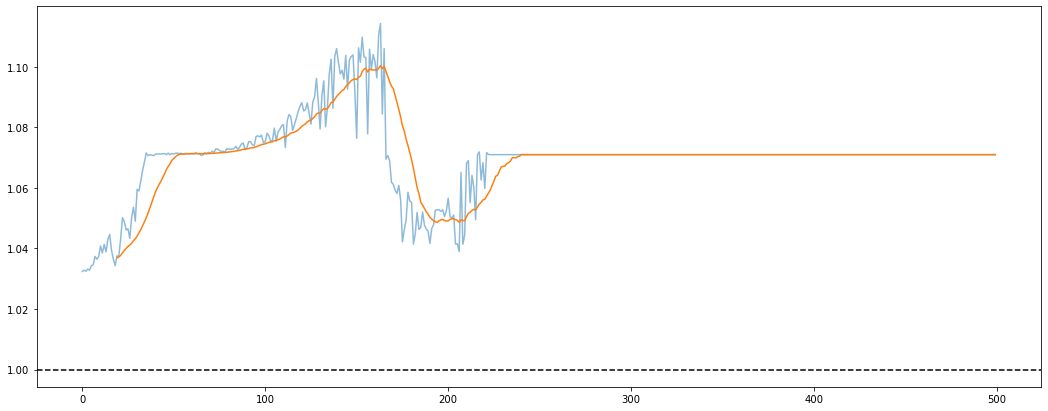

In [30]:
plt.figure(figsize=(18,7))
plt.plot(varr_list, alpha=0.5)
varr_list = pd.Series(varr_list)
plt.plot(varr_list.rolling(20).mean())
plt.axhline(y = 1, color = 'black', linestyle = '--')
#plt.axvline(x=223, color='black', linestyle = '--')
plt.show()

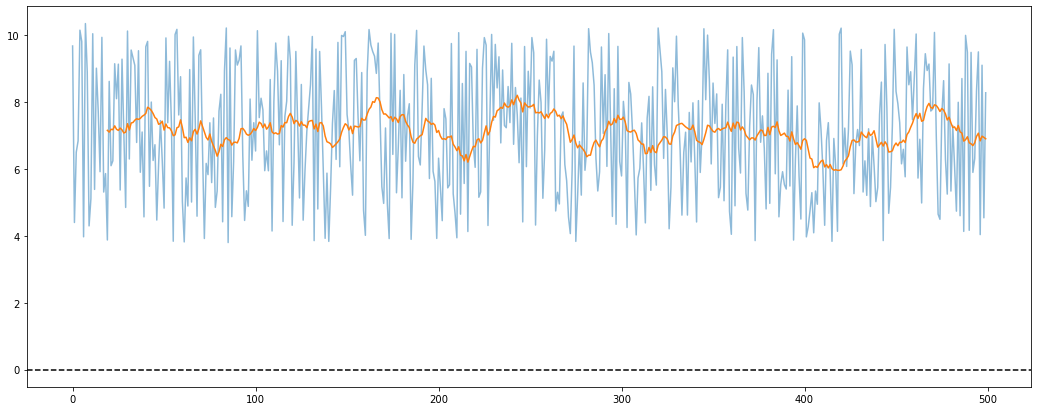

In [31]:
plt.figure(figsize=(18,7))
plt.plot(reward_list, alpha=0.5)
reward_list = pd.Series(reward_list)
plt.plot(reward_list.rolling(20).mean())
plt.axhline(y = 0, color = 'black', linestyle = '--')
#plt.axvline(x=223, color='black', linestyle = '--')
plt.show()

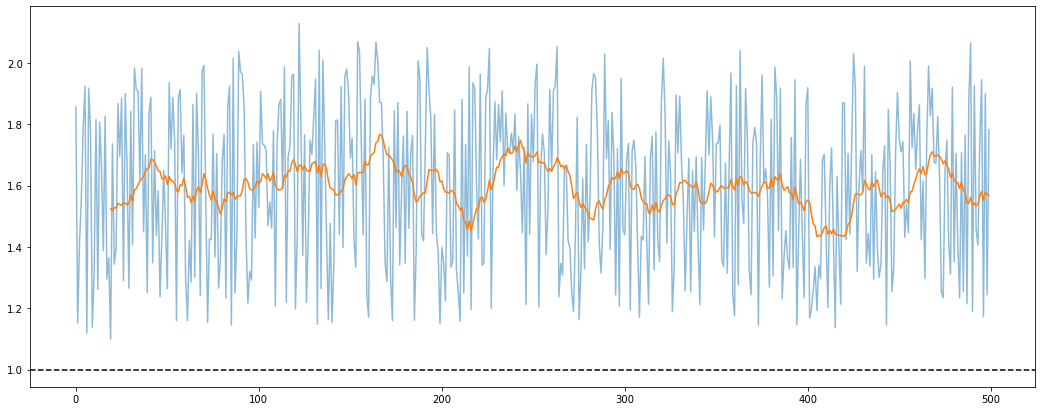

In [32]:
plt.figure(figsize=(18,7))
plt.plot(raw_return, alpha=0.5)
raw_return = pd.Series(raw_return)
plt.plot(raw_return.rolling(20).mean())
plt.axhline(y = 1, color = 'black', linestyle = '--')
#plt.axvline(x=223, color='black', linestyle = '--')
plt.show()

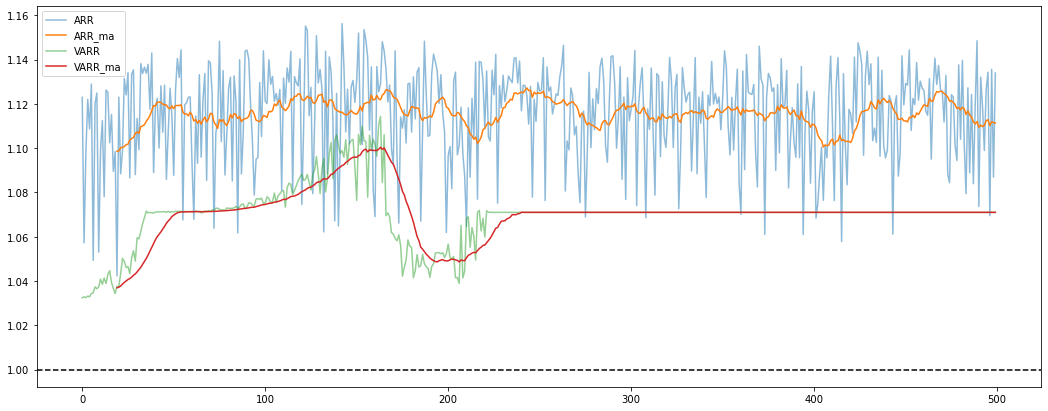

In [33]:
plt.figure(figsize=(18,7))
plt.plot(arr_list, alpha=0.5, label='ARR')
arr_list = pd.Series(arr_list)
plt.plot(arr_list.rolling(20).mean(), label='ARR_ma')
plt.plot(varr_list, alpha=0.5, label='VARR')
varr_list = pd.Series(varr_list)
plt.plot(varr_list.rolling(20).mean(), label='VARR_ma')
plt.axhline(y = 1, color = 'black', linestyle = '--')
#plt.axvline(x=223, color='black', linestyle = '--')
plt.legend()
plt.show()

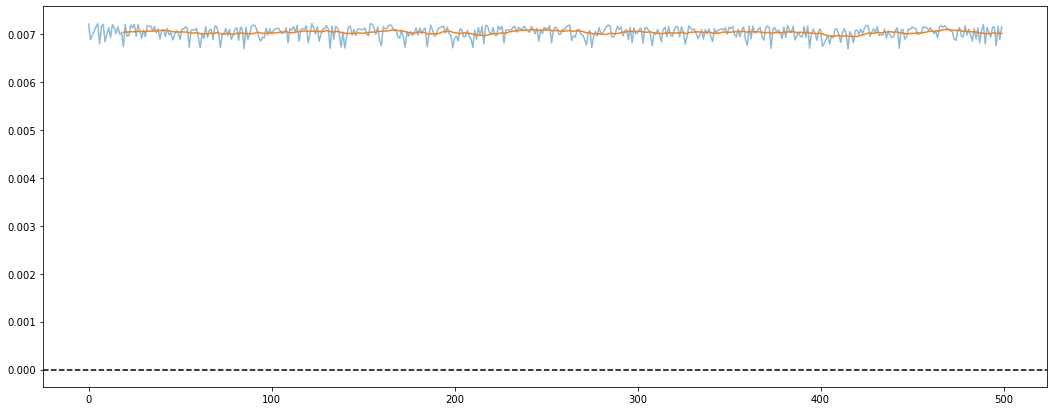

In [34]:
plt.figure(figsize=(18,7))
plt.plot(avg_rewards, alpha=0.5)
avg_rewards = pd.Series(avg_rewards)
plt.plot(avg_rewards.rolling(20).mean())
plt.axhline(y = 0, color = 'black', linestyle = '--')
#plt.axvline(x=223, color='black', linestyle = '--')
plt.show()

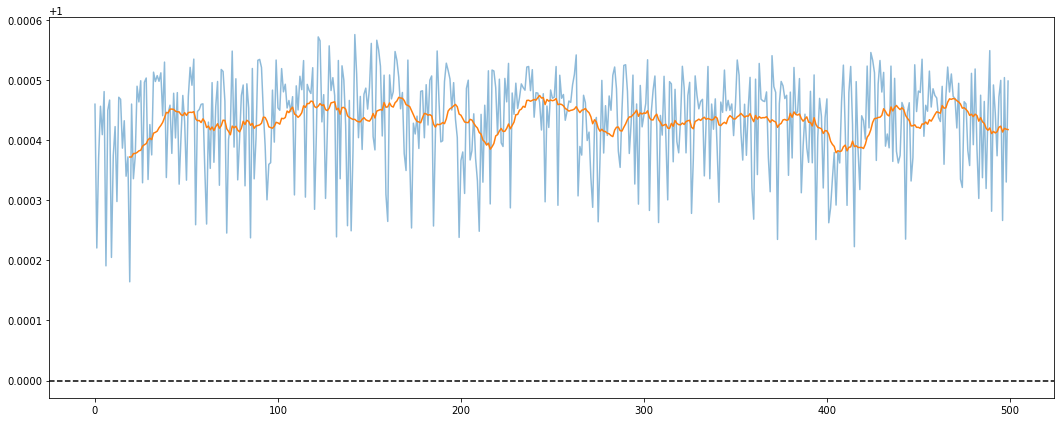

In [35]:
plt.figure(figsize=(18,7))
plt.plot(geomean_return, alpha=0.5)
geomean_return = pd.Series(geomean_return)
plt.plot(geomean_return.rolling(20).mean())
plt.axhline(y = 1, color = 'black', linestyle = '--')
#plt.axvline(x=223, color='black', linestyle = '--')
plt.show()

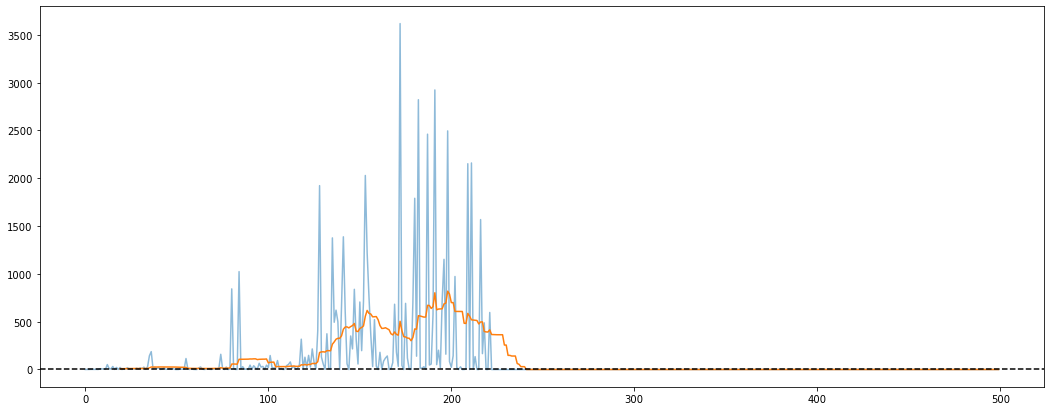

In [36]:
plt.figure(figsize=(18,7))
plt.plot(eps_aloss, alpha=0.5)
eps_aloss = pd.Series(eps_aloss)
plt.plot(eps_aloss.rolling(20).mean())
plt.plot(eps_valoss, alpha=0.75)
plt.axhline(y = 0, color = 'black', linestyle = '--')
#plt.ylim(-0.75, 0.5)
plt.show()

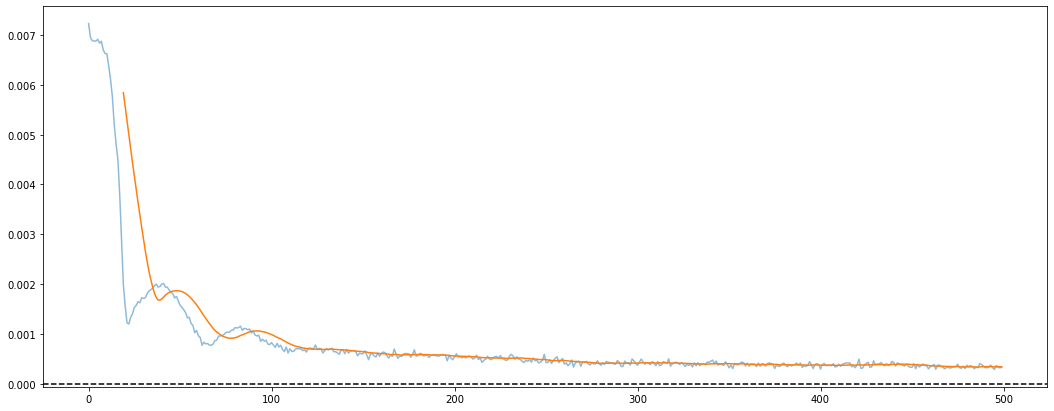

In [37]:
plt.figure(figsize=(18,7))
plt.plot(eps_closs, alpha=0.5)
eps_closs = pd.Series(eps_closs)
plt.plot(eps_closs.rolling(20).mean())
plt.plot(eps_vcloss, alpha=0.75)
plt.axhline(y = 0, color = 'black', linestyle = '--')
#plt.ylim(-0.75, 0.5)
plt.show()

In [50]:
done = False
state = test_env.reset()
cumprod_return = 1
rewards = []
states = []
actions = []
dones = []
values = []
returns = []
num_steps = 0
    
while not done:
    action = act(state)[0]
    actions.append(action)
    next_state, reward, done, info, day_return = test_env.step(action, DEFAULT_RISK_DISCOUNT)
    returns.append(day_return)
    dones.append(1-done)
    cumprod_return *= day_return
    rewards.append(reward)
    states.append(state)
    state = next_state
    num_steps += 1
    
cumsum = np.sum(rewards)
arr = (cumprod_return ** (1/(num_steps/252)))
geomean = (cumprod_return ** (1/num_steps))
mean = np.mean(rewards)

In [51]:
arr

1.212025223076754

In [52]:
actions

[array([0.25, 0.25, 0.25, 0.25], dtype=float32),
 array([0.25, 0.25, 0.25, 0.25], dtype=float32),
 array([0.25, 0.25, 0.25, 0.25], dtype=float32),
 array([0.25, 0.25, 0.25, 0.25], dtype=float32),
 array([0.25, 0.25, 0.25, 0.25], dtype=float32),
 array([0.25, 0.25, 0.25, 0.25], dtype=float32),
 array([0.25, 0.25, 0.25, 0.25], dtype=float32),
 array([0.25, 0.25, 0.25, 0.25], dtype=float32),
 array([0.25, 0.25, 0.25, 0.25], dtype=float32),
 array([0.25, 0.25, 0.25, 0.25], dtype=float32),
 array([0.25, 0.25, 0.25, 0.25], dtype=float32),
 array([0.25, 0.25, 0.25, 0.25], dtype=float32),
 array([0.25, 0.25, 0.25, 0.25], dtype=float32),
 array([0.25, 0.25, 0.25, 0.25], dtype=float32),
 array([0.25, 0.25, 0.25, 0.25], dtype=float32),
 array([0.25, 0.25, 0.25, 0.25], dtype=float32),
 array([0.25, 0.25, 0.25, 0.25], dtype=float32),
 array([0.25, 0.25, 0.25, 0.25], dtype=float32),
 array([0.25, 0.25, 0.25, 0.25], dtype=float32),
 array([0.25, 0.25, 0.25, 0.25], dtype=float32),
 array([0.25, 0.25, 

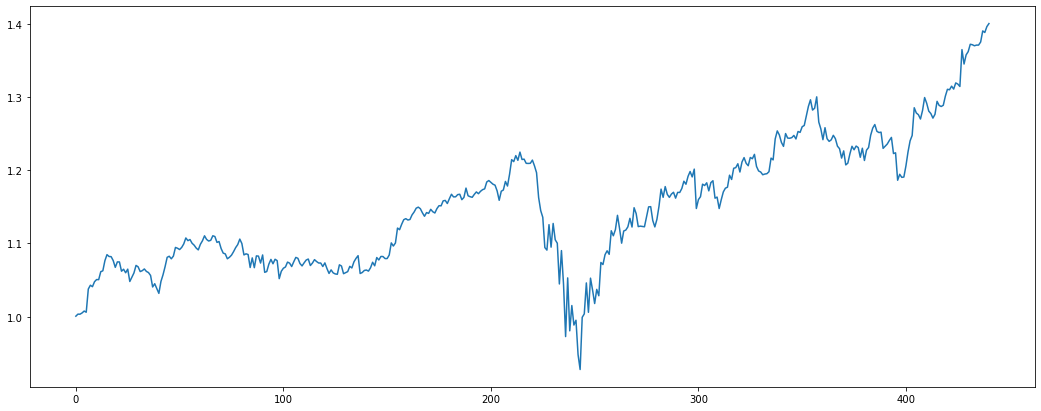

In [49]:
plt.figure(figsize=(18,7))
plt.plot(np.cumprod(returns))
plt.show()

In [53]:
return_series = pd.Series(returns)

In [54]:
with pd.HDFStore('test_results.h5') as store:
    store.put('CRP/test_set/returns', return_series)

In [40]:
actor.save_weights('PMA_actor_crp_500episodes.h5')
critic.save_weights('PMA_critic_crp_500episodes.h5')

In [41]:
actor.set_weights(best_actor_weights)
critic.set_weights(best_critic_weights)

In [45]:
actor.save_weights('PMA_actor_bestvalid_500episodes.h5')
critic.save_weights('PMA_critic_bestvalid_500episodes.h5')

In [43]:
series = pd.Series(replay_buffer)

In [44]:
with pd.HDFStore('sam_training.h5') as store:
    store.put('SAM/EIIE/625episodes/neg_loss/replay_buffer', series)

C:\ProgramData\Anaconda3\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '625episodes'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
C:\Users\isaac\AppData\Local\Temp\ipykernel_17368\4244756116.py:2: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->values] [items->None]

  store.put('SAM/EIIE/625episodes/neg_loss/replay_buffer', series)


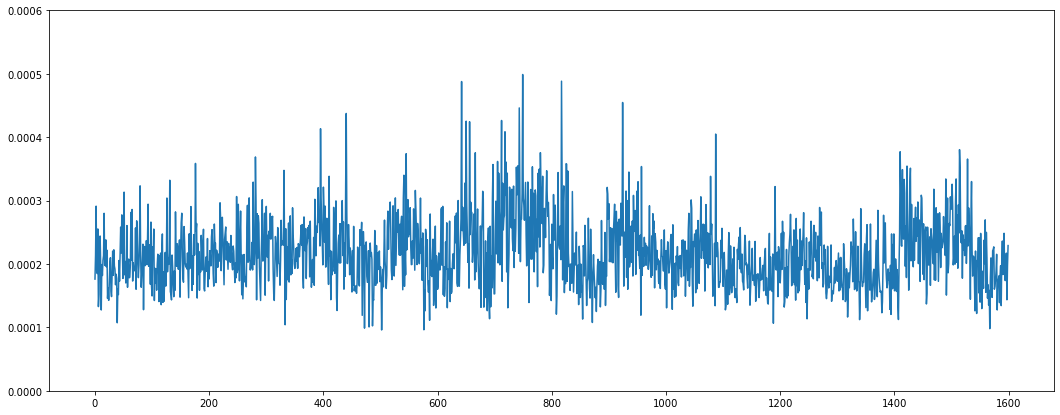

In [42]:
#1e-3
plt.figure(figsize=(18,7))
plt.plot(all_closs, alpha=1)
#plt.axhline(y = 0, color = 'black', linestyle = '--')
plt.ylim(0, 6e-4)
plt.show()

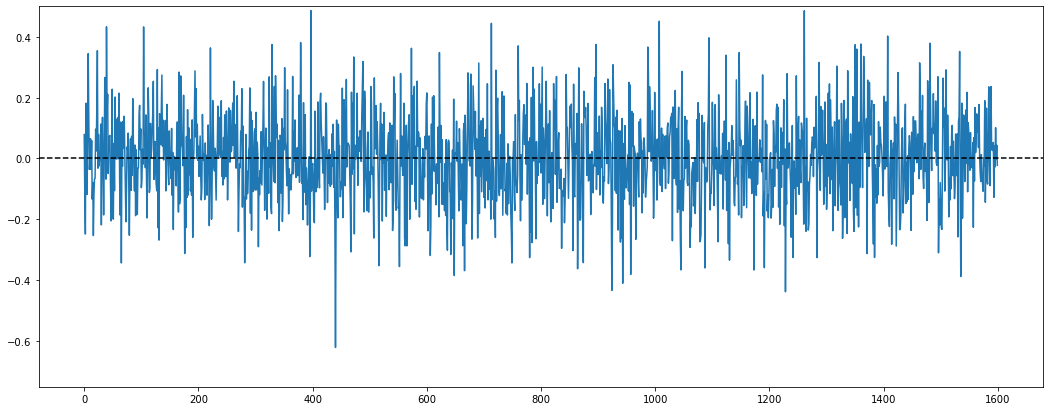

In [25]:
#1e-4
plt.figure(figsize=(18,7))
plt.plot(all_aloss, alpha=1)
plt.axhline(y = 0, color = 'black', linestyle = '--')
plt.ylim(-0.75, 0.5)
plt.show()

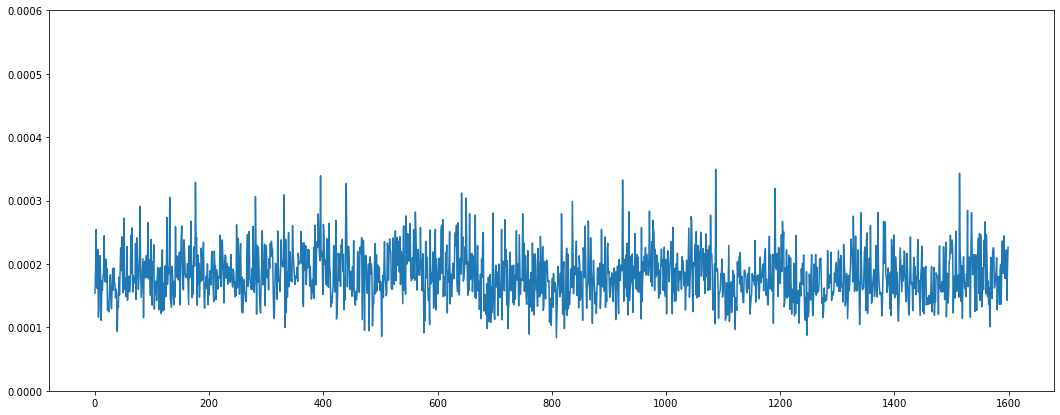

In [26]:
#1e-4
plt.figure(figsize=(18,7))
plt.plot(all_closs, alpha=1)
#plt.axhline(y = 0, color = 'black', linestyle = '--')
plt.ylim(0, 6e-4)
plt.show()

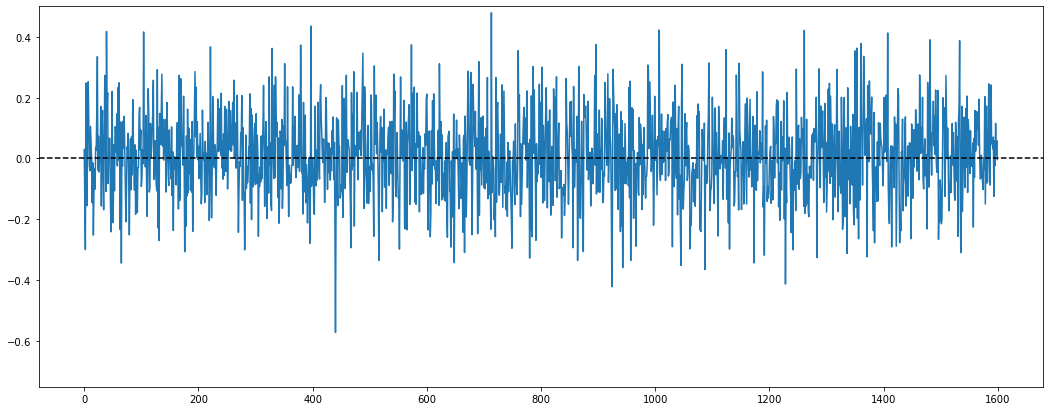

In [25]:
#1e-2
plt.figure(figsize=(18,7))
plt.plot(all_aloss, alpha=1)
plt.axhline(y = 0, color = 'black', linestyle = '--')
plt.ylim(-0.75, 0.5)
plt.show()

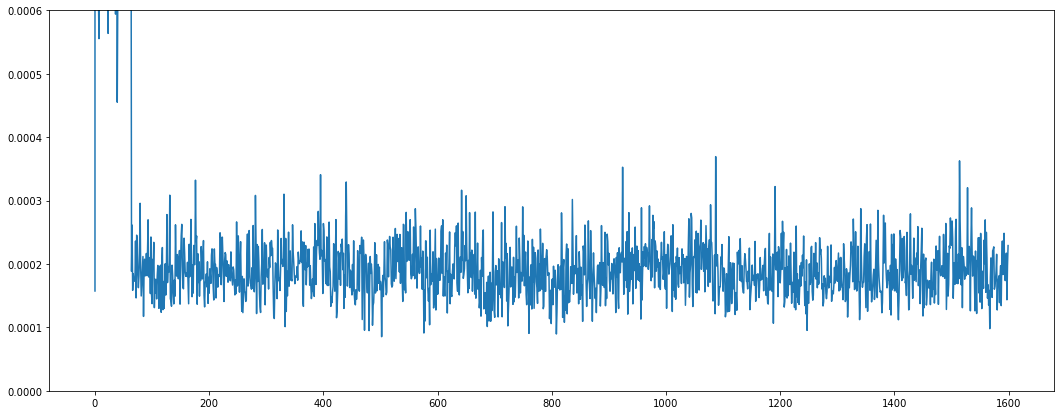

In [28]:
#1e-2
plt.figure(figsize=(18,7))
plt.plot(all_closs, alpha=1)
#plt.axhline(y = 0, color = 'black', linestyle = '--')
plt.ylim(0, 6e-4)
plt.show()